In [1]:
# Health Insurance Purchase Prediction - Complete ML Model
# Google Colab Ready Code

# ============================================================================
# STEP 1: INSTALL AND IMPORT REQUIRED LIBRARIES
# ============================================================================

!pip install openpyxl xgboost imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
# ============================================================================
# STEP 2: UPLOAD AND LOAD DATASET
# ============================================================================

from google.colab import files
print("📁 Please upload your Excel file...")
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

print(f"\n✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

📁 Please upload your Excel file...


Saving maharashtra_health_insurance_dataset.xlsx to maharashtra_health_insurance_dataset.xlsx

✅ Dataset loaded successfully!
Shape: (2000, 27)

First few rows:


,Customer_ID,Age,Gender,Marital_Status,Number_of_Dependents,Education_Level,Occupation,Annual_Income,City,Region_Type,Years_in_Current_Job,Smoker,Alcohol_Consumption,BMI,Chronic_Disease,Medical_Visits_Last_Year,Exercise_Frequency,Family_Medical_History,Previous_Insurance,Insurance_Awareness_Level,Online_Activity_Level,Bank_Account_Type,Existing_Loans,Monthly_Savings,Risk_Appetite,Contact_by_Agents_Count,Purchased_Health_Insurance
0,CUST00001,69,Female,Married,4,Professional Degree,IT Professional,3183821,Solapur,Semi-Urban,26,Yes,Never,26.1,NaN,0,Regular,Yes,No,High,Medium,Savings + Investment,Yes,46002,Medium,4,Yes
1,CUST00002,22,Male,Single,0,12th Pass,Businessman,199876,Shirpur,Semi-Urban,1,No,Regular,27.7,NaN,3,Occasional,No,Yes,Low,Medium,Savings,Yes,3503,Low,1,No
2,CUST00003,50,Male,Married,1,12th Pass,Bank Employee,1275774,Latur,Rural,20,No,Regular,27.9,Thyroid,7,Rare,Yes,Yes,Medium,Low,Savings + Investment,Yes,5979,High,2,Yes
3,CUST00004,25,Female,Single,1,Graduate,Doctor,1769791,Akola,Semi-Urban,4,No,Regular,25.2,NaN,3,Regular,Yes,No,Low,High,Savings + Investment,No,32755,High,9,Yes
4,CUST00005,18,Female,Single,0,Graduate,Teacher,387235,Dhule,Rural,-1,No,Never,30.9,NaN,2,Regular,Yes,No,Low,High,Savings + Investment,Yes,5671,Low,2,No


In [3]:
# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic info
print("\n1️⃣ Dataset Information:")
print(f"   - Total Records: {len(df)}")
print(f"   - Total Features: {len(df.columns)}")
print(f"   - Memory Usage: {df.memory_usage().sum() / 1024:.2f} KB")

print("\n2️⃣ Data Types:")
print(df.dtypes)

print("\n3️⃣ Missing Values:")
print(df.isnull().sum())

print("\n4️⃣ Statistical Summary:")
print(df.describe())

print("\n5️⃣ Target Variable Distribution:")
target_dist = df['Purchased_Health_Insurance'].value_counts()
print(target_dist)
print(f"\nClass Balance: {target_dist.values[1]/len(df)*100:.2f}% purchased insurance")



📊 EXPLORATORY DATA ANALYSIS

1️⃣ Dataset Information:
   - Total Records: 2000
   - Total Features: 27
   - Memory Usage: 422.00 KB

2️⃣ Data Types:
Customer_ID                    object
Age                             int64
Gender                         object
Marital_Status                 object
Number_of_Dependents            int64
Education_Level                object
Occupation                     object
Annual_Income                   int64
City                           object
Region_Type                    object
Years_in_Current_Job            int64
Smoker                         object
Alcohol_Consumption            object
BMI                           float64
Chronic_Disease                object
Medical_Visits_Last_Year        int64
Exercise_Frequency             object
Family_Medical_History         object
Previous_Insurance             object
Insurance_Awareness_Level      object
Online_Activity_Level          object
Bank_Account_Type              object
Existing_Loans


📈 DATA VISUALIZATIONS


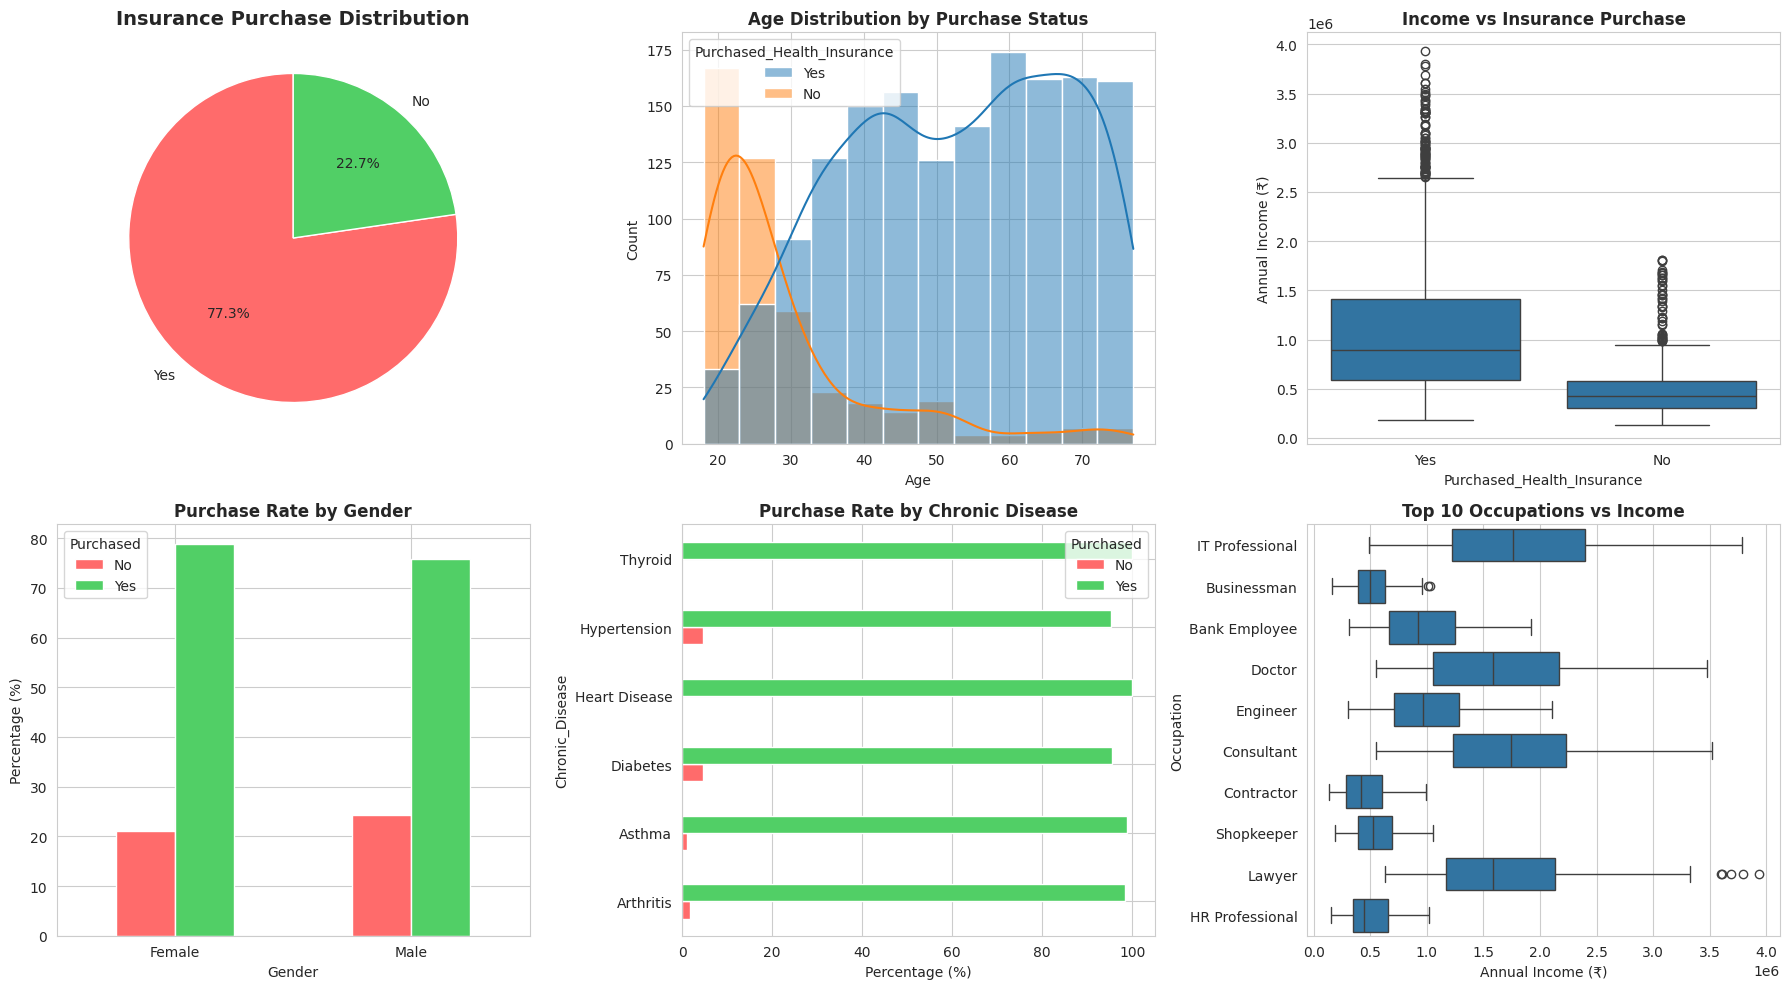


🔥 Correlation Analysis:


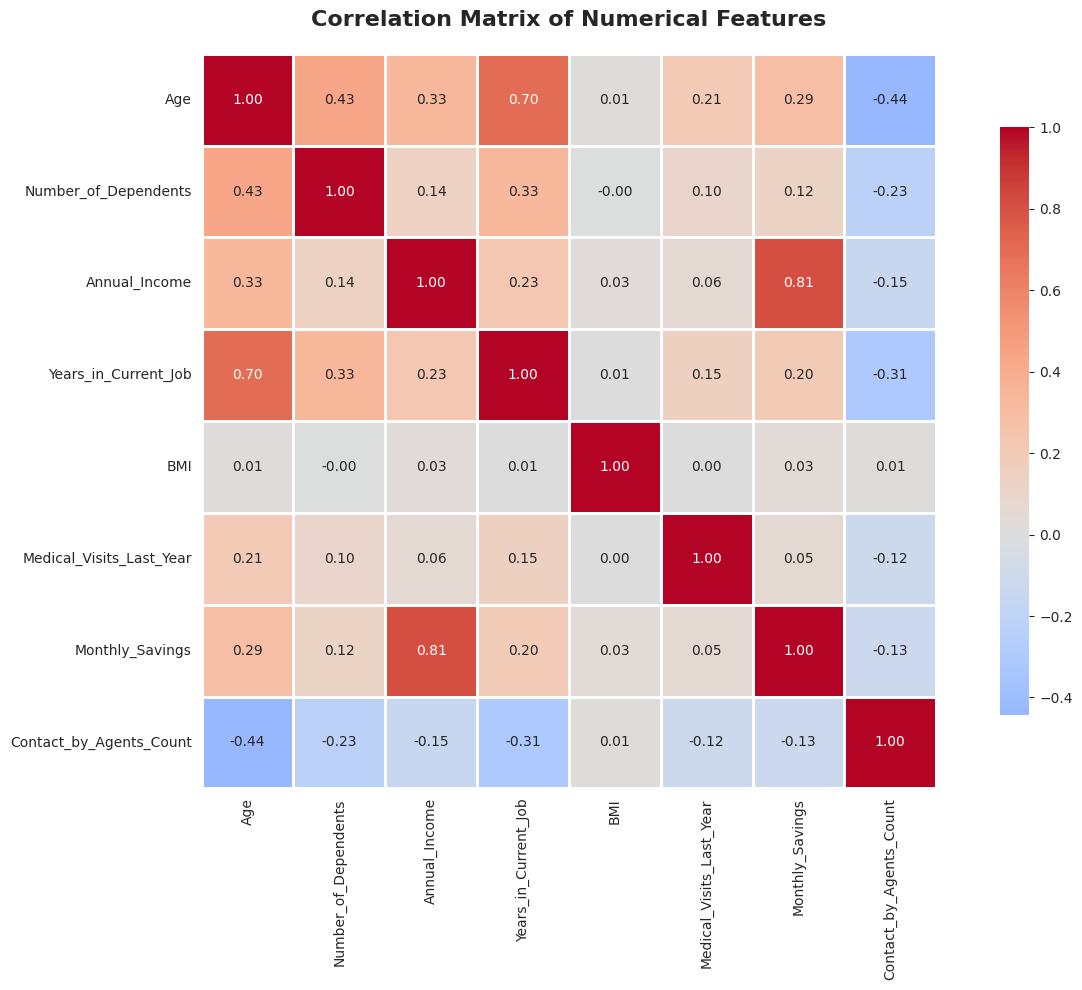

In [4]:
# ============================================================================
# STEP 4: DATA VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("📈 DATA VISUALIZATIONS")
print("="*80)

# Target Distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Target Distribution
target_counts = df['Purchased_Health_Insurance'].value_counts()
axes[0, 0].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%',
               colors=['#ff6b6b', '#51cf66'], startangle=90)
axes[0, 0].set_title('Insurance Purchase Distribution', fontsize=14, fontweight='bold')

# 2. Age Distribution
sns.histplot(data=df, x='Age', hue='Purchased_Health_Insurance', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Purchase Status', fontsize=12, fontweight='bold')

# 3. Income Distribution
sns.boxplot(data=df, x='Purchased_Health_Insurance', y='Annual_Income', ax=axes[0, 2])
axes[0, 2].set_title('Income vs Insurance Purchase', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Annual Income (₹)')

# 4. Gender Distribution
gender_purchase = pd.crosstab(df['Gender'], df['Purchased_Health_Insurance'], normalize='index') * 100
gender_purchase.plot(kind='bar', ax=axes[1, 0], color=['#ff6b6b', '#51cf66'])
axes[1, 0].set_title('Purchase Rate by Gender', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].legend(['No', 'Yes'], title='Purchased')

# 5. Chronic Disease Impact
disease_purchase = pd.crosstab(df['Chronic_Disease'], df['Purchased_Health_Insurance'], normalize='index') * 100
disease_purchase.plot(kind='barh', ax=axes[1, 1], color=['#ff6b6b', '#51cf66'])
axes[1, 1].set_title('Purchase Rate by Chronic Disease', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Percentage (%)')
axes[1, 1].legend(['No', 'Yes'], title='Purchased')

# 6. Occupation vs Income
top_occupations = df['Occupation'].value_counts().head(10).index
df_top_occ = df[df['Occupation'].isin(top_occupations)]
sns.boxplot(data=df_top_occ, y='Occupation', x='Annual_Income', ax=axes[1, 2])
axes[1, 2].set_title('Top 10 Occupations vs Income', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Annual Income (₹)')

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
print("\n🔥 Correlation Analysis:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numerical_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [5]:
# ============================================================================
# STEP 5: DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("⚙️ DATA PREPROCESSING")
print("="*80)

# Create a copy for processing
df_processed = df.copy()

# Drop Customer_ID as it's not useful for prediction
df_processed = df_processed.drop('Customer_ID', axis=1)

# Separate target variable
X = df_processed.drop('Purchased_Health_Insurance', axis=1)
y = df_processed['Purchased_Health_Insurance']

print(f"\n1️⃣ Features shape: {X.shape}")
print(f"2️⃣ Target shape: {y.shape}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n3️⃣ Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"4️⃣ Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Label Encoding for categorical variables
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target variable
y_encoded = LabelEncoder().fit_transform(y)

print(f"\n✅ Label encoding completed for {len(categorical_cols)} categorical columns")

# Feature Scaling
scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

print(f"✅ Feature scaling completed for {len(numerical_cols)} numerical columns")



⚙️ DATA PREPROCESSING

1️⃣ Features shape: (2000, 25)
2️⃣ Target shape: (2000,)

3️⃣ Categorical columns (17): ['Gender', 'Marital_Status', 'Education_Level', 'Occupation', 'City', 'Region_Type', 'Smoker', 'Alcohol_Consumption', 'Chronic_Disease', 'Exercise_Frequency', 'Family_Medical_History', 'Previous_Insurance', 'Insurance_Awareness_Level', 'Online_Activity_Level', 'Bank_Account_Type', 'Existing_Loans', 'Risk_Appetite']
4️⃣ Numerical columns (8): ['Age', 'Number_of_Dependents', 'Annual_Income', 'Years_in_Current_Job', 'BMI', 'Medical_Visits_Last_Year', 'Monthly_Savings', 'Contact_by_Agents_Count']

✅ Label encoding completed for 17 categorical columns
✅ Feature scaling completed for 8 numerical columns


In [6]:
# ============================================================================
# STEP 6: TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "="*80)
print("🔀 TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n✅ Data split completed:")
print(f"   - Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   - Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\n   Training target distribution:")
print(f"   - Class 0 (No): {sum(y_train==0)} ({sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"   - Class 1 (Yes): {sum(y_train==1)} ({sum(y_train==1)/len(y_train)*100:.1f}%)")



🔀 TRAIN-TEST SPLIT

✅ Data split completed:
   - Training set: 1600 samples (80.0%)
   - Test set: 400 samples (20.0%)

   Training target distribution:
   - Class 0 (No): 363 (22.7%)
   - Class 1 (Yes): 1237 (77.3%)


In [7]:
# ============================================================================
# STEP 7: MODEL TRAINING AND EVALUATION
# ============================================================================

print("\n" + "="*80)
print("🤖 MODEL TRAINING AND EVALUATION")
print("="*80)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate all models
results = []

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training {name}...")
    print(f"{'='*80}")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV Score': cv_mean
    })

    print(f"\n📊 {name} Results:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"   ROC-AUC:   {roc_auc:.4f}")
    print(f"   CV Score:  {cv_mean:.4f} (+/- {cv_scores.std():.4f})")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("📊 MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))



🤖 MODEL TRAINING AND EVALUATION

Training Logistic Regression...

📊 Logistic Regression Results:
   Accuracy:  0.9225
   Precision: 0.9484
   Recall:    0.9515
   F1-Score:  0.9499
   ROC-AUC:   0.9697
   CV Score:  0.9300 (+/- 0.0139)

Training Decision Tree...

📊 Decision Tree Results:
   Accuracy:  0.9000
   Precision: 0.9297
   Recall:    0.9417
   F1-Score:  0.9357
   ROC-AUC:   0.8500
   CV Score:  0.8925 (+/- 0.0102)

Training Random Forest...

📊 Random Forest Results:
   Accuracy:  0.9100
   Precision: 0.9226
   Recall:    0.9644
   F1-Score:  0.9430
   ROC-AUC:   0.9647
   CV Score:  0.9150 (+/- 0.0151)

Training Gradient Boosting...

📊 Gradient Boosting Results:
   Accuracy:  0.9275
   Precision: 0.9430
   Recall:    0.9644
   F1-Score:  0.9536
   ROC-AUC:   0.9817
   CV Score:  0.9431 (+/- 0.0137)

Training XGBoost...

📊 XGBoost Results:
   Accuracy:  0.9300
   Precision: 0.9404
   Recall:    0.9709
   F1-Score:  0.9554
   ROC-AUC:   0.9801
   CV Score:  0.9363 (+/- 0.0139)


🏆 BEST MODEL ANALYSIS

🥇 Best Model: XGBoost
   Accuracy: 0.9300


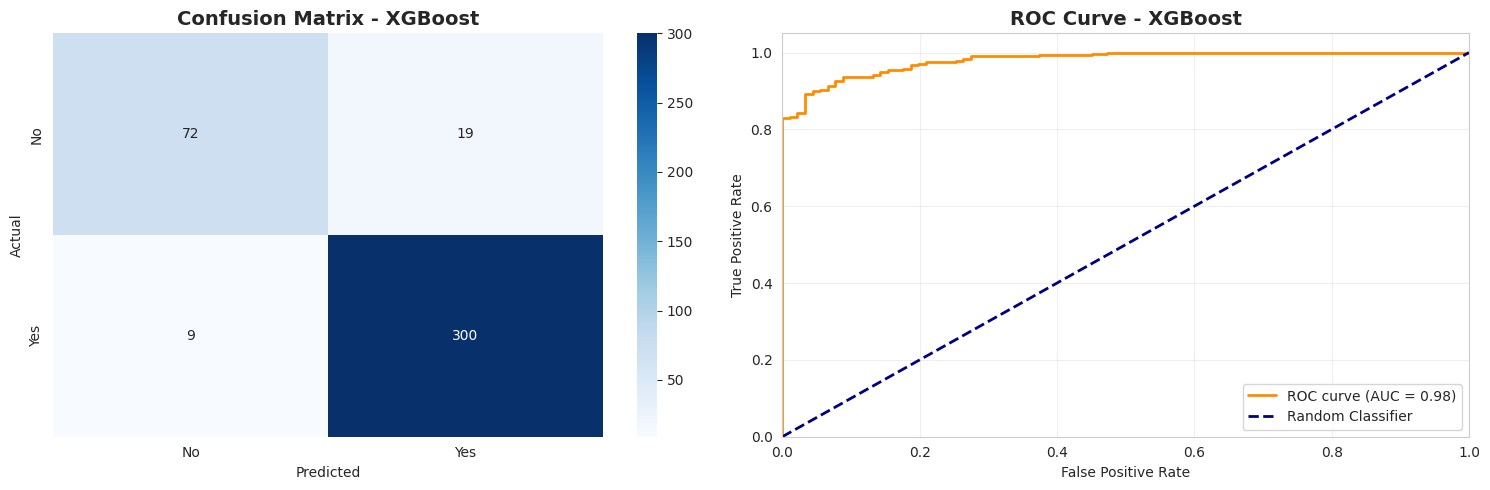


📋 Detailed Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.89      0.79      0.84        91
   Purchased       0.94      0.97      0.96       309

    accuracy                           0.93       400
   macro avg       0.91      0.88      0.90       400
weighted avg       0.93      0.93      0.93       400


🎯 FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
                  Feature  Importance
                      Age    0.274728
          Chronic_Disease    0.117461
       Previous_Insurance    0.102789
            Annual_Income    0.069405
     Number_of_Dependents    0.050913
   Family_Medical_History    0.046338
Insurance_Awareness_Level    0.038392
          Monthly_Savings    0.031625
                   Smoker    0.031021
          Education_Level    0.027449
        Bank_Account_Type    0.025438
     Years_in_Current_Job    0.019296
                      BMI    0.018578
            Risk_Appetite    0.018437
    

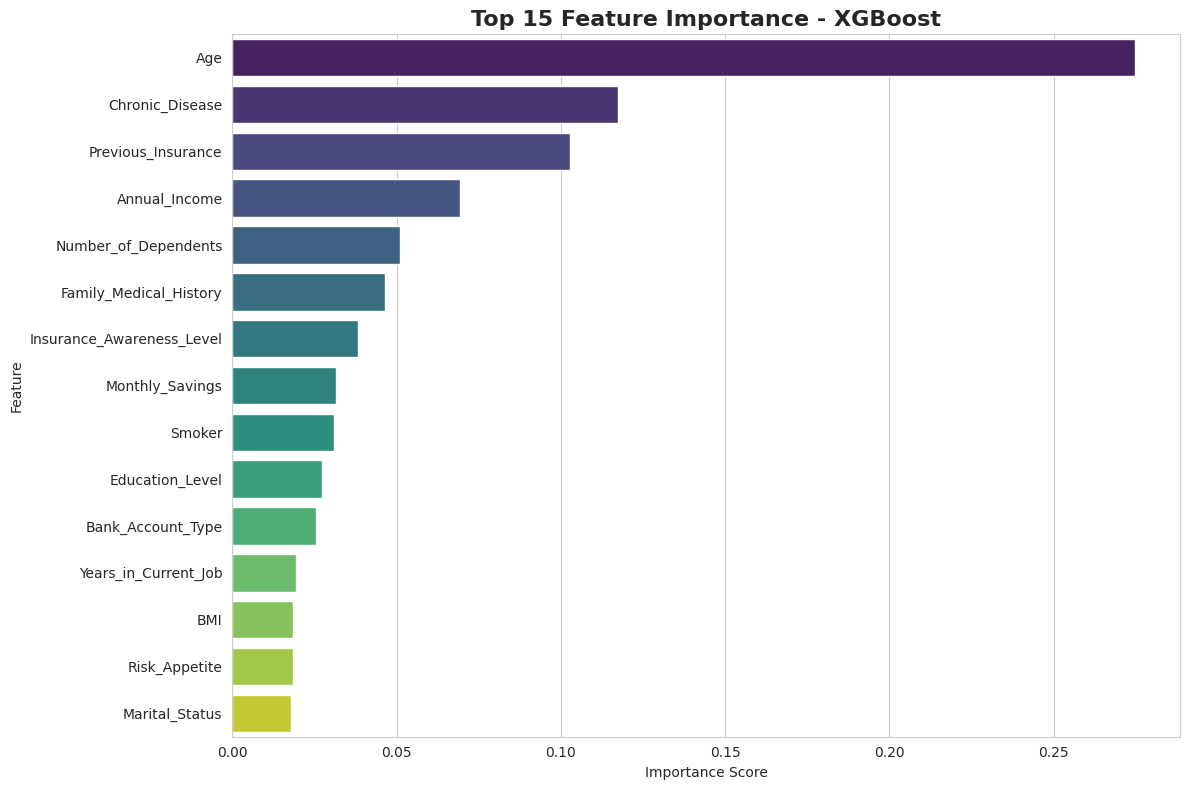

In [8]:
# ============================================================================
# STEP 8: BEST MODEL SELECTION AND DETAILED EVALUATION
# ============================================================================

print("\n" + "="*80)
print("🏆 BEST MODEL ANALYSIS")
print("="*80)

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n🥇 Best Model: {best_model_name}")
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

# Confusion Matrix
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve
if hasattr(best_model, 'predict_proba'):
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
    roc_auc = roc_auc_score(y_test, y_pred_proba_best)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Purchase', 'Purchased']))

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*80)
    print("🎯 FEATURE IMPORTANCE ANALYSIS")
    print("="*80)

    feature_importance = pd.DataFrame({
        'Feature': X_encoded.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Visualize top 15 features
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance.head(15)
    sns.barplot(data=top_15, y='Feature', x='Importance', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()


In [9]:
# ============================================================================
# STEP 9: HYPERPARAMETER TUNING (FOR BEST MODEL)
# ============================================================================

print("\n" + "="*80)
print("🔧 HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    }
}

if best_model_name in param_grids:
    print(f"\n🔍 Performing Grid Search for {best_model_name}...")
    print("This may take a few minutes...")

    grid_search = GridSearchCV(
        estimator=models[best_model_name],
        param_grid=param_grids[best_model_name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\n✅ Grid Search Completed!")
    print(f"\n🎯 Best Parameters: {grid_search.best_params_}")
    print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

    print(f"\n📊 Tuned Model Performance:")
    print(f"   Accuracy: {tuned_accuracy:.4f}")
    print(f"   Improvement: {(tuned_accuracy - results_df.iloc[0]['Accuracy'])*100:.2f}%")
else:
    print(f"\n⚠️ Hyperparameter tuning not configured for {best_model_name}")
    tuned_model = best_model



🔧 HYPERPARAMETER TUNING

🔍 Performing Grid Search for XGBoost...
This may take a few minutes...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Grid Search Completed!

🎯 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
🎯 Best CV Score: 0.9463

📊 Tuned Model Performance:
   Accuracy: 0.9250
   Improvement: -0.50%


In [10]:
# ============================================================================
# STEP 10: SAVE THE BEST MODEL
# ============================================================================

print("\n" + "="*80)
print("💾 SAVING MODEL AND ARTIFACTS")
print("="*80)

import pickle

# Save the tuned model
with open('best_health_insurance_model.pkl', 'wb') as f:
    pickle.dump(tuned_model if 'tuned_model' in locals() else best_model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X_encoded.columns.tolist(), f)

print("\n✅ Model and artifacts saved successfully!")
print("   - best_health_insurance_model.pkl")
print("   - scaler.pkl")
print("   - label_encoders.pkl")
print("   - feature_names.pkl")



💾 SAVING MODEL AND ARTIFACTS

✅ Model and artifacts saved successfully!
   - best_health_insurance_model.pkl
   - scaler.pkl
   - label_encoders.pkl
   - feature_names.pkl


In [12]:
# ============================================================================
# STEP 11: PREDICTION FUNCTION
# ============================================================================

print("\n" + "="*80)
print("🔮 PREDICTION FUNCTION")
print("="*80)

def predict_insurance_purchase(new_data):
    """
    Predict health insurance purchase for new customer data

    Parameters:
    new_data: dict with all required features

    Returns:
    prediction and probability
    """
    # Create dataframe
    new_df = pd.DataFrame([new_data])

    # Encode categorical variables
    for col in categorical_cols:
        if col in new_df.columns:
            # Handle potential unseen labels by coercing errors
            new_df[col] = label_encoders[col].transform(new_df[col])


    # Scale numerical features
    new_df[numerical_cols] = scaler.transform(new_df[numerical_cols])

    # Ensure column order matches training data
    new_df = new_df[X_encoded.columns]

    # Predict
    prediction = tuned_model.predict(new_df)[0] if 'tuned_model' in locals() else best_model.predict(new_df)[0]
    probability = tuned_model.predict_proba(new_df)[0] if 'tuned_model' in locals() else best_model.predict_proba(new_df)[0]

    result = "Will Purchase" if prediction == 1 else "Will Not Purchase"
    confidence = probability[prediction] * 100

    return result, confidence

# Example prediction
print("\n📝 Example Prediction:")
sample_customer = {
    'Age': 35,
    'Gender': 'Male',
    'Marital_Status': 'Married',
    'Number_of_Dependents': 2,
    'Education_Level': 'Graduate',
    'Occupation': 'Software Engineer',
    'Annual_Income': 800000,
    'City': 'Pune',
    'Region_Type': 'Metro',
    'Years_in_Current_Job': 8,
    'Smoker': 'No',
    'Alcohol_Consumption': 'Occasional',
    'BMI': 24.5,
    'Chronic_Disease': np.nan, # Changed 'None' to np.nan
    'Medical_Visits_Last_Year': 2,
    'Exercise_Frequency': 'Regular',
    'Family_Medical_History': 'Yes',
    'Previous_Insurance': 'No',
    'Insurance_Awareness_Level': 'High',
    'Online_Activity_Level': 'High',
    'Bank_Account_Type': 'Savings + Investment',
    'Existing_Loans': 'Yes',
    'Monthly_Savings': 25000,
    'Risk_Appetite': 'Medium',
    'Contact_by_Agents_Count': 5
}

result, confidence = predict_insurance_purchase(sample_customer)
print(f"\n🎯 Prediction: {result}")
print(f"📊 Confidence: {confidence:.2f}%")

print("\n" + "="*80)
print("✨ MODEL PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("\n🎉 Your health insurance prediction model is ready to use!")
print("📊 Model Accuracy: {:.2f}%".format(results_df.iloc[0]['Accuracy'] * 100))
print("🎯 Best Model: {}".format(best_model_name))
print("\n💡 You can now use the predict_insurance_purchase() function to make predictions!")


🔮 PREDICTION FUNCTION

📝 Example Prediction:

🎯 Prediction: Will Purchase
📊 Confidence: 100.00%

✨ MODEL PIPELINE COMPLETED SUCCESSFULLY!

🎉 Your health insurance prediction model is ready to use!
📊 Model Accuracy: 93.00%
🎯 Best Model: XGBoost

💡 You can now use the predict_insurance_purchase() function to make predictions!
